## Loading Required Libraries 

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import cv2
import os

In [23]:
# Suppressing warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [24]:
# GPU configuration 

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

## Load image dataset

In [25]:
data = tf.keras.utils.image_dataset_from_directory('/Users/kavu_rojasara/Downloads/archive/train', 
                                                   image_size=(32, 32))

Found 100000 files belonging to 2 classes.


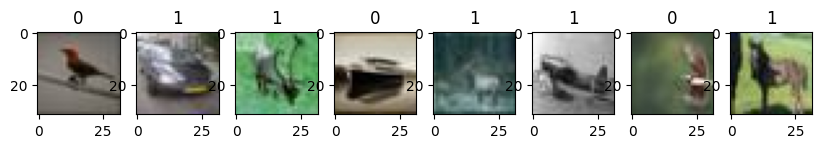

In [26]:
data_it = data.as_numpy_iterator()
batch = data_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [27]:
data = data.map(lambda x, y : (x/255, y))

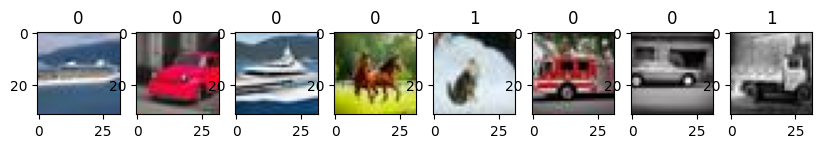

In [28]:
# Showing scaled sample of images
scaled_it = data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

In [29]:
data_dir = '/Users/kavu_rojasara/Downloads/archive/train'
image_size = (32, 32)
batch_size = 32

In [30]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=42
)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.


In [31]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=42
)

Found 100000 files belonging to 2 classes.
Using 20000 files for validation.


## Data Preprocessing

In [32]:
class_names = train_data.class_names

In [33]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [34]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
# Load pre-trained ResNet50 model base

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False  # Freeze the base model

In [36]:
# Model construction

model = models.Sequential([
    data_augmentation,
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [37]:
# Learning rate scheduler
initial_learning_rate = 0.001

In [38]:
def lr_scheduler(epoch, lr):
    return lr * 0.95

In [39]:
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [40]:
# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [42]:
# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[lr_schedule, early_stopping])

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 144s 57ms/step - accuracy: 0.7876 - loss: 0.4681 - val_accuracy: 0.8528 - val_loss: 0.3379 - learning_rate: 9.5000e-04
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 145s 58ms/step - accuracy: 0.8380 - loss: 0.3700 - val_accuracy: 0.8630 - val_loss: 0.3225 - learning_rate: 9.0250e-04
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 145s 58ms/step - accuracy: 0.8456 - loss: 0.3531 - val_accuracy: 0.8540 - val_loss: 0.3330 - learning_rate: 8.5737e-04
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 146s 58ms/step - accuracy: 0.8511 - loss: 0.3445 - val_accuracy: 0.8637 - val_loss: 0.3199 - learning_rate: 8.1451e-04
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1640s 656ms/step - accuracy: 0.8555 - loss: 0.3362 - val_accuracy: 0.8694 - val_loss: 0.3057 - learning_rate: 7.7378e-04
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 107s 43ms/step - accuracy: 0.8566 - loss: 0.3316 - val_accuracy: 0.8587 - val_loss: 0.3220 - learning_rate: 7.3509e-04
Epoch 7/10
2500/2500 ━━━━━━━━━━━

In [43]:
# Evaluate the model on the test set
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/kavu_rojasara/Downloads/archive/test',
    image_size=image_size,
    batch_size=batch_size
)

Found 20000 files belonging to 2 classes.


In [44]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8612 - loss: 0.3113
Test Accuracy: 86.45%


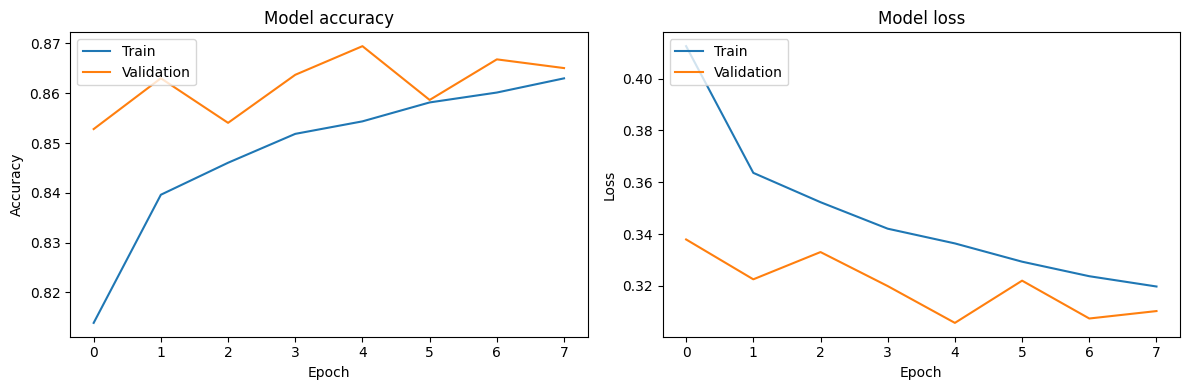

In [45]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
# Save the model
model.save('model/ai_imageclassifier.keras')

In [47]:
# Load the model
loaded_model = tf.keras.models.load_model('model/ai_imageclassifier.keras')

In [48]:
# Make predictions on a single image
image_path = '/Users/kavu_rojasara/Downloads/archive/test/REAL/0000 (8).jpg'

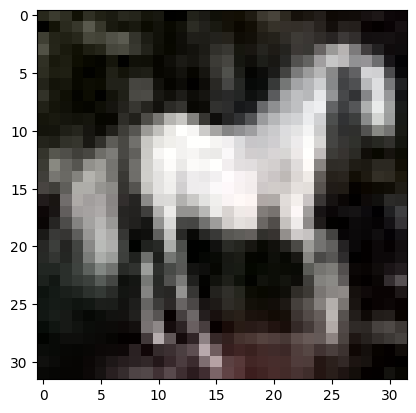

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicted class: REAL


In [49]:
try:
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not read the image from {image_path}")
    img = cv2.resize(img, image_size[:2])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
    resize = tf.image.resize(img, image_size)
    y_pred = model.predict(np.expand_dims(resize / 255, 0))

    if y_pred > 0.5:
        print(f'Predicted class: REAL')
    else:
        print(f'Predicted class: AI')

except Exception as e:
    print(f"Error: {e}")

In [50]:
# Evaluate the model on the test set
y_true = []
y_pred_probs = []

for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    y_pred_probs.extend(model.predict(X).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

In [51]:
# Convert probabilities to binary predictions
y_pred = np.array(y_pred_probs) > 0.5

In [52]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

In [53]:
# Classification Report
class_report = classification_report(y_true, y_pred, target_names=class_names)

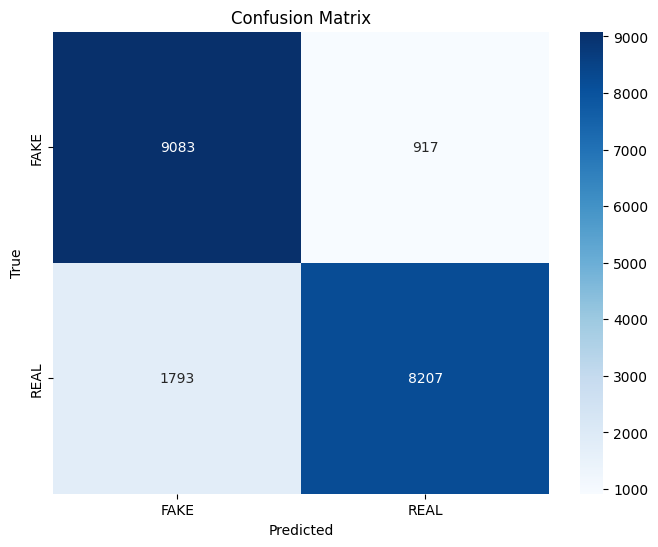

In [54]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [55]:
# Display Classification Report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.84      0.91      0.87     10000
        REAL       0.90      0.82      0.86     10000

    accuracy                           0.86     20000
   macro avg       0.87      0.86      0.86     20000
weighted avg       0.87      0.86      0.86     20000

